In [2]:
import argparse
import os
from datetime import datetime
from os import path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import trange

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from tabular.algo import model_based
from tabular.algo.model_based import ModelBased
from tabular.algo.value_iteration import ModelFree
from tabular.finite_mdp import FiniteMDP

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


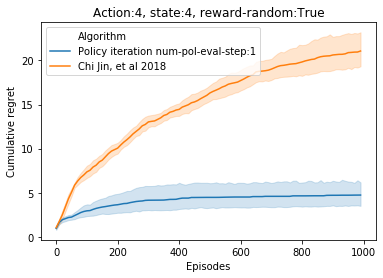

In [4]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Finite-horizon MDP")
    parser.add_argument("--n-episode", type=int, default=1000)
    parser.add_argument("--n-action", type=int, default=2)
    parser.add_argument("--n-step", type=int, default=2)
    parser.add_argument("--state-per-stage", type=int, default=2)
    parser.add_argument("--p", type=int, default=0.05)
    parser.add_argument("--alpha", type=int, default=0.1)
    parser.add_argument("--n-run", type=int, default=10)
    parser.add_argument("--n-pol-eval-step", type=int, default=1)
    parser.add_argument("--c", type=float, default=0.1)
    parser.add_argument("--random-reward", action="store_true", default=True)
    args = parser.parse_args('--n-episode 1000 --n-action 4 --n-step 2 --state-per-stage 2 --c 0.1 --n-run 10'.split())
    setting = vars(args)

    env = FiniteMDP(setting)

    regret_df = []
    step = int(max(setting["n_episode"] / 100, 1))
    episode_index = np.arange(start=0, stop=setting["n_episode"], step=step)
    for _ in trange(setting["n_run"]):
        algorithm_set = [
            ModelBased(algorithm_type=model_based.POLICY_ITERATION, using_previous_estimate=False),
            ModelFree(),
        ]
        for algorithm in algorithm_set:
            regret, _ = algorithm.run(setting['c'], setting, env)
            regret = regret[::step]

            cumulative_regret = np.cumsum(regret)
            regret_df.append(
                pd.DataFrame(
                    data={
                        "Algorithm": algorithm.name,
                        "Episode": episode_index,
                        "Cumulative_regret": cumulative_regret,
                    }
                )
            )
    regret_df = pd.concat(regret_df)
    sns_plot = sns.lineplot(
        data=regret_df, x="Episode", y="Cumulative_regret", hue="Algorithm"
    )
    sns_plot.set(xlabel="Episodes", ylabel="Cumulative regret")
    sns_plot.legend()
    plt.title(
        "Action:{}, state:{}, reward-random:{}".format(
            setting["n_action"],
            setting["n_state"],
            setting["random_reward"],
        )
    )
    plt.show()